### 【問題1】ラグランジュの未定乗数法による最急降下
### 【問題2】サポートベクターの決定
### 【問題3】推定
### 【問題4】学習と推定
### 【問題5】決定領域の可視化

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
%config InlineBackend.figure_formats = ['svg']

import warnings
warnings.simplefilter('ignore')

In [2]:
from matplotlib.colors import ListedColormap

class DecisionPlotter:
    def __init__(self, X, y, classifier, test_idx=None):
        self.X = X
        self.y = y
        self.classifier = classifier
        self.test_idx = test_idx
        self.colors = ['#de3838', '#007bc3', '#ffd12a']
        self.markers = ['o', 'x', ',']
        self.labels = ['setosa', 'versicolor', 'virginica']
    
    def plot(self):
        cmap = ListedColormap(self.colors[:len(np.unique(self.y))])
        # グリットポイントの生成
        xx1, xx2 = np.meshgrid(
            np.arange(self.X[:,0].min()-1, self.X[:,0].max()+1, 0.01),
            np.arange(self.X[:,1].min()-1, self.X[:,1].max()+1, 0.01))
        # 各meshgridの予測値を求める
        Z = self.classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        # 等高線のプロット
        plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        # classごとにデータ点をプロット
        for idx, cl, in enumerate(np.unique(self.y)):
            plt.scatter(
                x=self.X[self.y==cl, 0], y=self.X[self.y==cl, 1], 
                alpha=0.8, 
                c=self.colors[idx],
                marker=self.markers[idx],
                label=self.labels[idx])
        # テストデータの強調
        if self.test_idx is not None:
            X_test, y_test = self.X[self.test_idx, :], self.y[self.test_idx]
            plt.scatter(
                X_test[:, 0], X_test[:, 1], 
                alpha=0.9, 
                c='None', 
                edgecolor='gray', 
                marker='o', 
                s=100, 
                label='test set')
        plt.legend()

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()  # irisデータセットの読み込み
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['class'] = iris.target
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
df_iris = df_iris[df_iris['class'] != 2]  # class = 0, 1のデータのみを取得
df_iris = df_iris[['petal length (cm)', 'petal width (cm)', 'class']]
X = df_iris.iloc[:, :-1].values
y = df_iris.iloc[:, -1].values
y = np.where(y==0, -1, 1)  # class = 0のラベルを-1に変更する

print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')

X.shape: (100, 2)
y.shape: (100,)


In [5]:
from sklearn.preprocessing import StandardScaler

# 標準化のインスタンスを生成（平均=0, 標準偏差=1 に標準化）
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [6]:
from sklearn.model_selection import train_test_split

# train data 80%, test data 20%の割合で分割
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42, stratify=y)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (80, 2)
X_test.shape: (20, 2)
y_train.shape: (80,)
y_test.shape: (20,)


In [7]:
class HardMarginSVM:
    """
    Attributes
    -------------
    eta : float
        学習率
    epoch : int
        エポック数
    random_state : int
        乱数シード
    is_trained : bool
        学習完了フラグ
    num_samples : int
        学習データのサンプル数
    num_features : int
        特徴量の数
    w : NDArray[float]
        パラメータベクトル: (num_features, )のndarray
    b : float
        切片パラメータ
    alpha : NDArray[float]
        未定乗数: (num_samples, )のndarray

    Methods
    -----------
    fit -> None
        学習データについてパラメータベクトルを適合させる
    predict -> NDArray[int]
        予測値を返却する
    """
    def __init__(self, eta=0.001, epoch=1000, random_state=42):
        self.eta = eta
        self.epoch = epoch
        self.random_state = random_state
        self.is_trained = False

    def fit(self, X, y):
        """
        学習データについてパラメータベクトルを適合させる

        Parameters
        --------------
        X : NDArray[NDArray[float]]
            学習データ: (num_samples, num_features)の行列
        y : NDArray[float]
            学習データの教師ラベル: (num_samples)のndarray
        """
        self.num_samples = X.shape[0]
        self.num_features = X.shape[1]
        # パラメータベクトルを0で初期化
        self.w = np.zeros(self.num_features)
        self.b = 0
        # 乱数生成器
        rgen = np.random.RandomState(self.random_state)
        # 正規乱数を用いてalpha(未定乗数)を初期化
        self.alpha = rgen.normal(loc=0.0, scale=0.01, size=self.num_samples)

        # 最急降下法を用いて双対問題を解く
        for _ in range(self.epoch):
            self._cycle(X, y)
        
        # サポートベクトルのindexを取得
        indexes_sv = [i for i in range(self.num_samples) if self.alpha[i] != 0]
        # w を計算 (式1)
        for i in indexes_sv:
            self.w += self.alpha[i] * y[i] * X[i]
        # b を計算 (式2)
        for i in indexes_sv:
            self.b += y[i] - (self.w @ X[i])
        self.b /= len(indexes_sv)
        # 学習完了のフラグを立てる
        self.is_trained = True

    def predict(self, X):
        """
        予測値を返却する

        Parameters
        --------------
        X : NDArray[NDArray[float]]
            分類したいデータ: (any, num_features)の行列

        Returns
        ----------
        result : NDArray[int]
            分類結果 -1 or 1: (any, )のndarray
        """
        if not self.is_trained:
            raise Exception('This model is not trained.')

        hyperplane = X @ self.w + self.b
        result = np.where(hyperplane > 0, 1, -1)
        return result
        
    def _cycle(self, X, y):
        """
        勾配降下法の1サイクル

        Parameters
        --------------
        X : NDArray[NDArray[float]]
            学習データ: (num_samples, num_features)の行列
        y : NDArray[float]
            学習データの教師ラベル: (num_samples)のndarray
        """
        y = y.reshape([-1, 1])  # (num_samples, 1)の行列にreshape
        H = (y @ y.T) * (X @ X.T)  # (式3)
        # 勾配ベクトルを計算
        grad = np.ones(self.num_samples) - H @ self.alpha  # (式4)
        # alpha(未定乗数)の更新
        self.alpha += self.eta * grad
        # alpha(未定乗数)の各成分はゼロ以上である必要があるので負の成分をゼロにする
        self.alpha = np.where(self.alpha < 0, 0, self.alpha)

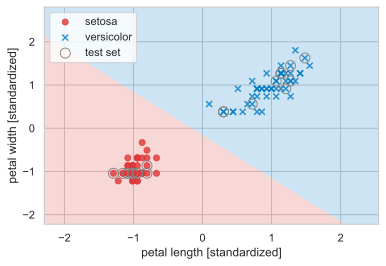

In [8]:
# svmのパラメータを学習
hard_margin_svm = HardMarginSVM()
hard_margin_svm.fit(X_train, y_train)

# 学習データとテストデータを結合
X_comb = np.vstack((X_train, X_test))
y_comb = np.hstack((y_train, y_test))
# プロット
dp = DecisionPlotter(X=X_comb, y=y_comb, classifier=hard_margin_svm, test_idx=range(len(y_train), len(y_comb)))
dp.plot()
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.show()

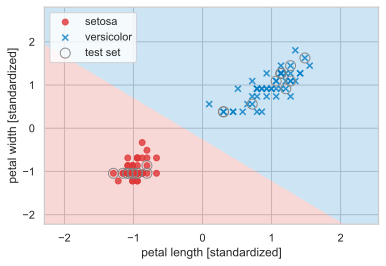

In [9]:
from sklearn import svm

sk_svm = svm.LinearSVC(C=1e10, random_state=42)
sk_svm.fit(X_train, y_train)

# 訓練データとテストデータを結合
X_comb = np.vstack((X_train, X_test))
y_comb = np.hstack((y_train, y_test))
# プロット
dp = DecisionPlotter(X=X_comb, y=y_comb, classifier=sk_svm, test_idx=range(len(y_train), len(y_comb)))
dp.plot()
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.show()